# Домашнее задание: Heart Disease — классификация
В данной работе проводится небольшой разведочный анализ данных (EDA) датасета Heart Disease и обучение моделей.

Цель - на реальном медицинском датасете сравнить несколько алгоритмов классификации и проанализировать их поведение.

---

## 1. Первичный анализ данных
Загрузим датасет Heart Disease из модуля sklearn.datasets и посмотрим на вид семплов.

In [29]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

data = fetch_openml(name="heart-disease", as_frame=True)
df = data.frame
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


### 1.1 Общая структура

Размер датасета:

In [30]:
df.shape

(303, 14)

Типы признаков:

In [31]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target      float64
dtype: object

Также проверим, есть ли в датасете прропуски:

In [32]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Видим, что пропусков нет и все признаки по типу числовые, но есть подозрение, что категориальные признаки в нашем датасете имеют числовые значения. Как это проверить?

Воспользуемся методом nunique(), с помощью которого подсчитаем количество уникальных значений каждого признака. Если их мало в сравнении с размером датасета, то это категориальный признак, иначе - числовой:

In [33]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

Строк в датасете 303, поэтому можем сделать следующий вывод:

- sex, cp, fbs, restecg, exang, slope, ca, thal - категориальные признаки
- age, trestbps, chol, thalach, oldpeak - числовые признаки

Признаки sex, cp, fbs, restecg, exang, slope, ca, thal являются **категориальными**, поскольку принимают ограниченное число дискретных значений, каждое из которых соответствует определённой категории (например, тип боли в груди или результат ЭКГ), а не измеряемой величине.

Признаки age, trestbps, chol, thalach, oldpeak являются **числовыми**, так как представляют измеряемые величины и имеют смысл упорядоченной шкалы.

### 1.2 Целевая переменная

Пропусков в наших данных нет, но чтобы сделать окончательный вывод, есть ли в наших данных проблема, давайте проверим датасет на дизбаланс классов:

In [34]:
df['target'].value_counts()

target
1.0    165
0.0    138
Name: count, dtype: int64

In [35]:
len(df[df['target'] == 1]) / len(df)

0.5445544554455446

Видим, что в датасете **~54.5%** пациентов с заболеванием сердца, дисбаланс есть, но небольшой.

Ориентироваться только на accuracy даже при малом дисбалансе не совсем хорошая идея, поэтому кроме **accuracy** задействуем такие метрики, как **precision**, **recall**, **f1**.

### 1.3 Анализ признаков

Построим графики распределения признаков **age** (возраст), **chol** (уровень холестерина) и **cp** (тип боли в груди у пациента):

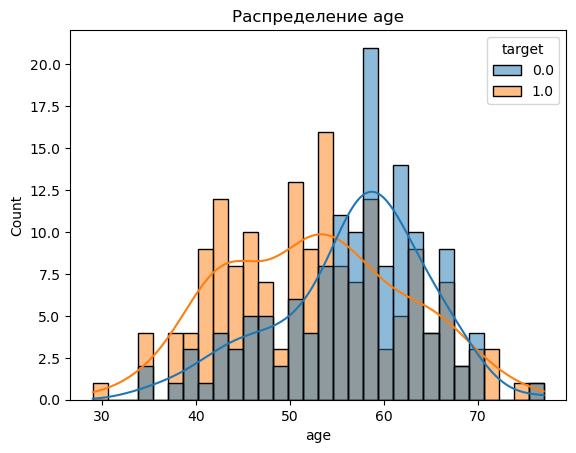

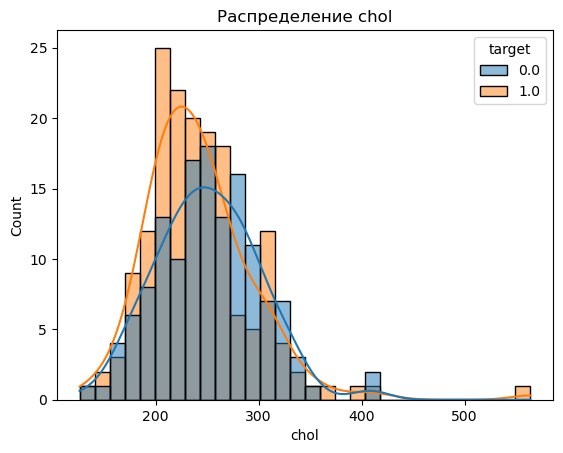

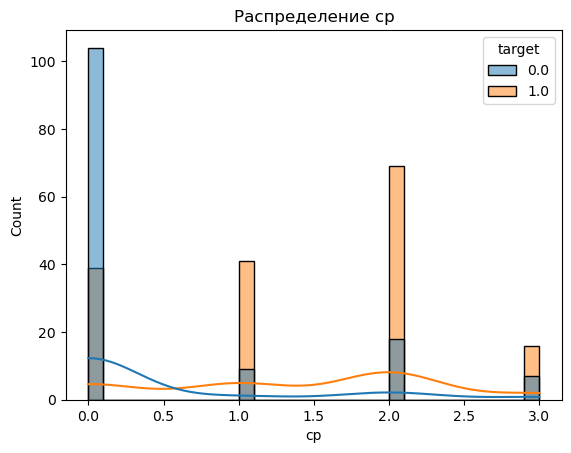

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


features = df[['age', 'chol', 'cp']]

for col in features:
    sns.histplot(data=df, x=col, hue='target', kde=True, bins=30)
    plt.title(f"Распределение {col}")
    plt.show()

Как видно из графиков, первые 2 признака плохо разделяют данные, поскольку:
- Большой общий диапазон для классов
- Плохо разделяют данные

Признак **cp** разделяет данные намного лучше. Получается, что тип боли в груди — один из самых диагностических признаков при сердечных заболеваниях. При cp = 0 (отсутствие боли) преобладает класс 0,  ином случае - класс 1. Этот признак очень хорошо разделяет классы визуально.

---

## 2. Подготовка данных
### 2.1 Разбиение

Разобьем данные на train и test с помощью встроенной функции sklearn, используя стратификацию. Но зачем нам использовать стратицикацию?

Дело в том, что наши данные не совсем сбалансированные, убедившись в этом в прошлом пункте. Если train и test будут иметь отличные от исходного датасета распределения классов, модель может получить не совсем объективную оценку качества. Поэтому важно, чтобы во всех выборках сохранялось распределение исходного датасета.

In [37]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((242, 13), (61, 13))

### 2.2 Подготовка признаков
Отберём категориальные и числовые признаки по п. 1:

In [38]:
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

**Закодируем** категориальные и **масштабируем** числовые признаки (можно сделать сразу с помощью sklearn.compose.ColumnTransformer дя лучшей интеграции с PipeLine):

In [39]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

Масштабирование очень важно для обучения некоторых моделей.
1. Если данные не масштабированы, то признаки с большей дисперсией значений будут **доминировать** над признаками с меньшей дисперсией значений.

2. При градиентном бустинге веса для признаков с большими значениями могут меняться **слишком быстро** и перескакивать оптимум модели, в то время как для признаков с меньшими значениями обучение будет проходить **слишком долго**. Если данные масштабированы, градиентный бустинг работает **эффективно** для всех данных.

3. Регуляризация ввиду разности весов будет **неравномерно** влиять на веса фичей при отсутствии масштабирования.

---

## 3. Обучение моделей и подбор гиперпараметров
Напишем удобную функцию для проверки качества модели:

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

### 3.1 Logistic Regression
Обучим модель логистической регрессии с гиперпараметром С = [0.01, 0.1, 1, 10]

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression())
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='f1',
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
grid_lr.best_params_

{'model__C': 1}

Для нашей задачи полагаю, что важнейшей из данных метрик является **recall**, т.к. нам важно не пропустить ни одного больного (Минимизация количества ошибок II рода для нашей задачи приоритетнее). Но нам также важно, чтобы не так много здоровых людей отправлялись на доп. исследования (**precision**). Поэтому лучшей метрикой для максимизации будет **f1**, которая учитывает и recall, и precision (среднее гармоническое) и лучшим значением гиперпараметра для нашей модели будет **C=1**.

### 3.2 kNN
Обучим модель k-ближайших с гиперпараметром n_neighbors=[3, 5, 7, 11]

In [42]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('prep', preprocessor),
    ('model', KNeighborsClassifier())
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 11]
}

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid_knn,
    cv=5,
    scoring='f1',
)

grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
grid_knn.best_params_

{'model__n_neighbors': 7}

### 3.3 Decision Tree
Обучим модель Decision Tree с гиперпараметром max_depth=[3, 5, 7, None]

In [43]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeClassifier())
])

param_grid_dt = {
    'model__max_depth': [3, 5, 7, None]
}

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid_dt,
    cv=5,
    scoring='f1',
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
grid_dt.best_params_

{'model__max_depth': 3}

### 3.4 Оценка качества
Узнаем, какой из видов моделей показал лучший результат:

In [44]:
final_results = pd.DataFrame({
    'LogReg': get_metrics(best_lr, X_test, y_test),
    'kNN': get_metrics(best_knn, X_test, y_test),
    'DecisionTree': get_metrics(best_dt, X_test, y_test)
}).T

final_results

,accuracy,precision,recall,f1
LogReg,0.868852,0.857143,0.909091,0.882353
kNN,0.786885,0.750000,0.909091,0.821918
DecisionTree,0.737705,0.717949,0.848485,0.777778


Из результатов видно, что модель логистической регрессии показала себя наилучшим образом на наших данных. Скорее всего, данные очень хорошо разделимы линейно после масштабирования, поэтому результаты показали хоть и небольшую, но доминацию логистической регрессии.

---

## 4. Анализ результатов
Получим Confusion Matrix для нашей модели логистической регрессии:

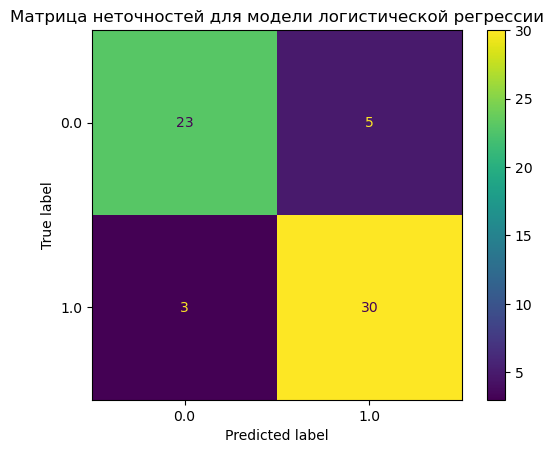

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test)
plt.title("Матрица неточностей для модели логистической регрессии")
plt.show()

Видно, что наша модель минимизировала ошибки II рода до минимума (FN=3). Возможно, чтобы из свести к нулю, необходимо протестировать и другие параметры: ввести регуляризацию L1 или скомбинированную версию L1 и L2 - Elastic Net, class_weight и другие.

### Выводы
1. Лучший результат показала модель **логистической регрессии**: у неё самые высокие точность (accuracy ≈ 0.869), precision (0.857), recall (0.909) и F1-мера (0.882).

2. Конфликт между precision и recall проявляется при сравнении моделей: у kNN такой же высокий recall (0.909), но значительно более низкий precision (0.75) – это означает, что, стремясь найти все положительные объекты, модель делает много ложных срабатываний. У дерева решений оба показателя ниже.

3. Опираться только на accuracy недостаточно, потому что она не отражает распределение ошибок по классам (**данные несбалансированы**). Например, в матрице неточностей видно, что логистическая регрессия лучше распознаёт класс 1 (30 верных против 5 ошибок), чем класс 0 (23 верных против 3 ошибок), но accuracy **скрывает** эту детализацию. Кроме того, при возможном дисбалансе классов accuracy может быть высокой за счёт предсказания **доминирующего** класса, поэтому для полной оценки необходимы precision и recall.

---

## Бонус
Попробуем изменить баланс классов с помощью гиперпараметра class_weight='balanced'

In [46]:
pipe_balanced_lr = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(class_weight='balanced'))
])

param_grid_balanced_lr = {
    'model__C': [0.01, 0.1, 1, 10]
}

grid_balanced_lr = GridSearchCV(
    pipe_balanced_lr,
    param_grid_balanced_lr,
    cv=5,
    scoring='f1',
)

grid_balanced_lr.fit(X_train, y_train)

best_balanced_lr = grid_balanced_lr.best_estimator_
grid_balanced_lr.best_params_

{'model__C': 10}

Лучшее значение гиперпараметра С изменилось с 1 на 10. Сравним модели по метрикам:

In [47]:
bonus_results = pd.DataFrame({
    'LogReg': get_metrics(best_lr, X_test, y_test),
    'Balanced LogReg': get_metrics(best_balanced_lr, X_test, y_test)
}).T

bonus_results

,accuracy,precision,recall,f1
LogReg,0.868852,0.857143,0.909091,0.882353
Balanced LogReg,0.852459,0.852941,0.878788,0.865672


Почему при балансировке данных результаты ухудшились?

Когда мы задаем параметр class_weight='balanced', модель присваивает большие веса миноритарному классу, и малые - мажоритарному, чтобы лучше классифицировать данные. Наши данные обладают примерно равным распределением (54% на 46%), поэтому может быть такое, что балансировка только ухудшит результаты по интересующим нас метрикам, так как будет сильнее штрафовать за ложное предсказание класса, который не так сильно мал по отношению к мажоритарному.

Попробуем обучить модель CatBoost - мощную модель градиентного бустинга:

In [48]:
from catboost import CatBoostClassifier


pipe_cb = Pipeline([
    ('prep', preprocessor),
    ('model', CatBoostClassifier(
        verbose=0,
        random_state=42
    ))
])

param_grid_cb = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__iterations': [200, 500]
}

grid_cb = GridSearchCV(
    pipe_cb,
    param_grid_cb,
    cv=5,
    scoring='f1',
)

grid_cb.fit(X_train, y_train)

best_cb = grid_cb.best_estimator_
grid_cb.best_params_

{'model__depth': 4, 'model__iterations': 500, 'model__learning_rate': 0.01}

Сравним модели LogReg и CatBoost:

In [50]:
lr_vs_cb_results = pd.DataFrame({
    'LogReg': get_metrics(best_lr, X_test, y_test),
    'CatBoost': get_metrics(best_cb, X_test, y_test)
}).T

lr_vs_cb_results

,accuracy,precision,recall,f1
LogReg,0.868852,0.857143,0.909091,0.882353
CatBoost,0.836066,0.810811,0.909091,0.857143


Почему модель CatBoost несмотря на свою популярность и похвалы сработала хуже обычной модели логистической регрессии?

Могу преположить, что наши данные хорошо линейно разделимы, поэтому обычная линейная модель с нашей задачей справляется лучше, чем сложная модель бустинга. Бустинги подходят для сложных, нелинейных данных, а наш датасет очень простой, поэтому достаточно простой линейной модели чтобы решить нашу задачу.